# CNN Image Classification
The model in this notebook will be trained to classify between two types of images: One with malignent cancer cells, and one with normal cancer cells.
The pathology images used for training and testing can be found on [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) 

<a name='1'></a>
## Part 1: Data Preprocessing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torchvision
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
# Declare some variables that will be used throughout the notebook
train_img_dir = "e:\\Documents\\Computer Vision\\ImageData\\train"
labels = pd.read_csv('train_labels.csv')
malignant = labels.loc[labels['label']==1]['id'].to_numpy()    # get the ids of malignant cases
normal = labels.loc[labels['label']==0]['id'].to_numpy()       # get the ids of the normal cases

<a name='1.1'></a>
### Part 1.1: EDA

Note: A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [3]:
# Checking the attributes and length of labels dataframe
print(len(labels))
labels.head()

220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Note to self: It is important to check the class distribution in the training set to avoid bad generalization

In [4]:
labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

#### Visualization of the training dataset images

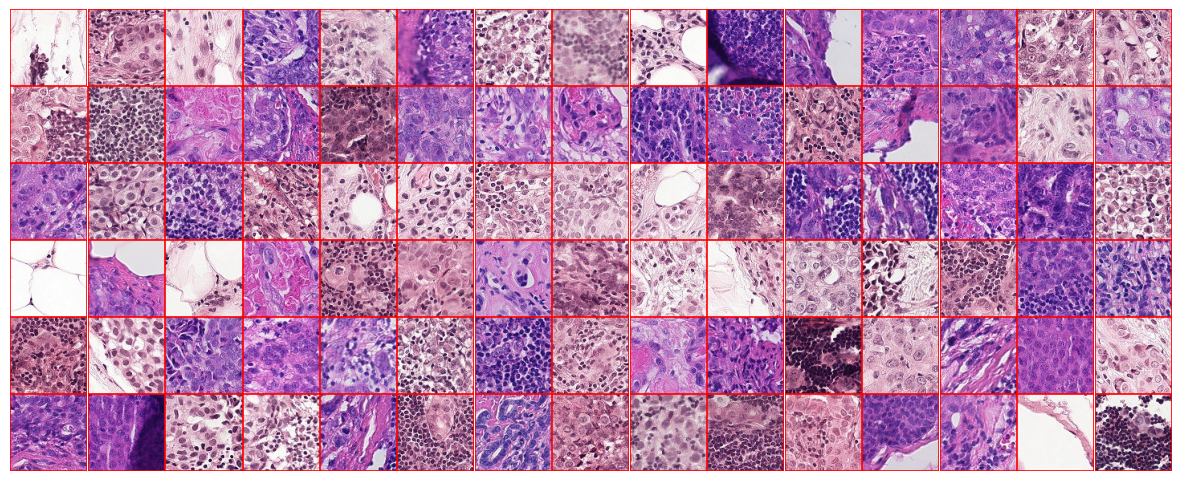

In [5]:
# Create a subplot to display train examples
nrows,ncols=6,15
fig,ax = plt.subplots(nrows,ncols,figsize=(15,6))
plt.subplots_adjust(wspace=0, hspace=0) 

# Get the last nrows*ncols images and display
for i,j in enumerate(malignant[:nrows*ncols]):
    fname = os.path.join(train_img_dir ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='red')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

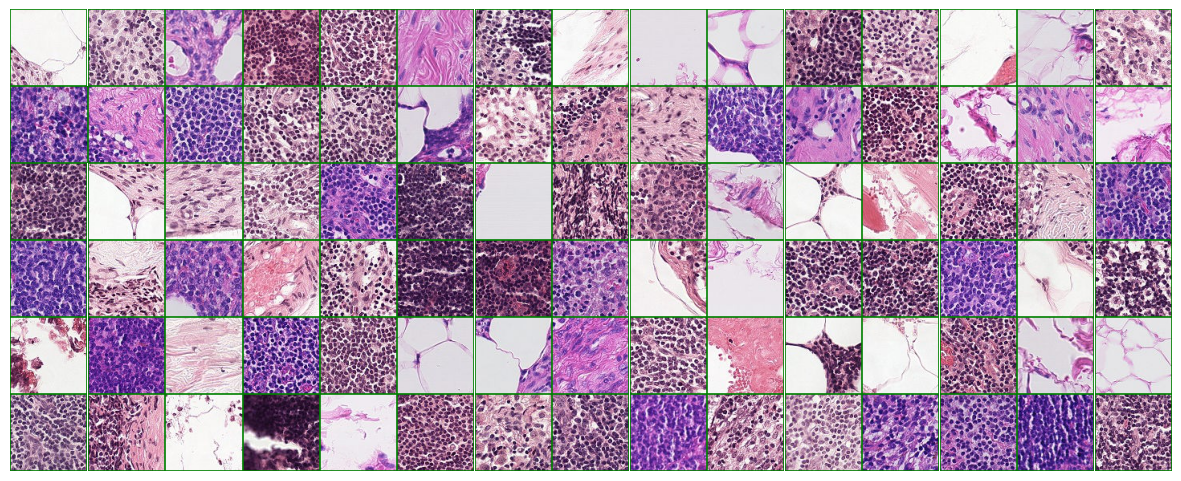

In [15]:
nrows,ncols=6,15
fig,ax = plt.subplots(nrows,ncols,figsize=(15,6))
plt.subplots_adjust(wspace=0, hspace=0) 

for i,j in enumerate(normal[:nrows*ncols]):
    fname = os.path.join(train_img_dir ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='green')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

### Part 1.2: Prepare dataset

In [35]:
class HistopathologicCancerDataset(Dataset):
    """
    This is our custom dataset class which will load the images, perform transforms on them,
    and load their corresponding labels.
    To create this, we need to override the __init__, __getitem__, and __len__ methods.
    Variables:
        labels_df(DataFrame): Has 2 attribute: Image_name, Label
        img_dir(String): Path to the image directory
        images(List): Full name of the images to be used
    """
    def __init__(self, img_dir, pos_id, neg_id, max_size=1000, transform=None):
        """
        From the list of positive and negative id, create a dataset with the same number of negative and positive data points.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.pos_id_list = []
        self.neg_id_list = []
        self.images = []

        pos_no = int(max_size*0.5)
        neg_no = max_size - pos_no
        random.seed(0)
        random.shuffle(pos_id)
        random.seed(1)
        random.shuffle(neg_id)

        # Add to the list of positive and negative images
        for x in pos_id: 
            if len(self.pos_id_list) == pos_no:
                break
            path = os.path.join(self.img_dir, x + ".tif")
            if os.path.exists(path): # If the file exists in image directory
                self.pos_id_list.append(x) # Add it to the list of positive images
        for x in neg_id:
            if len(self.neg_id_list) == neg_no:
                break
            path = os.path.join(self.img_dir, x + ".tif")
            if os.path.exists(path): # If the file exists in image directory
                self.neg_id_list.append(x) # Add it to the list of negative images

        self.images = self.pos_id_list + self.neg_id_list
        random.seed(0)
        random.shuffle(self.images)

        print(len(self.images) == max_size)

    def __getitem__(self, idx):
        """
        Open image, apply transforms and return with label
        Return: Object sample with 3 attributes:
            image: Image tensor
            label: Image label(0 or 1)
        """
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name + ".tif")
        image = Image.open(img_path)  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        if img_name in self.pos_id_list:
            correct_label = 1
        else:
            correct_label = 0

        return image, correct_label
    
    def __len__(self):
        return len(self.images)

#### Create train and validation dataloader

In [29]:
train_dataset = HistopathologicCancerDataset(
    img_dir=train_img_dir,
    pos_id=normal[:40000], neg_id=malignant[:40000],
    transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5), 
                transforms.RandomVerticalFlip(p=0.5),  
                transforms.RandomRotation(45),         
                transforms.ToTensor()]),
    max_size=6400
)

True
False


In [37]:
valid_dataset = HistopathologicCancerDataset(
    img_dir=train_img_dir,
    pos_id=normal[40001:60000], neg_id=malignant[40001:60000],
    transform=transforms.ToTensor(),
    max_size=1600
)

True


Recheck the size of train + valid dataset and put them into a DataLoader

In [38]:
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(valid_dataset))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle = False,
)
val_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle = False,
)

Train dataset size: 6400
Validation dataset size: 1600


#### Check the dimension of objects in the dataset/dataloader

In [24]:
# getting the torch tensor image & target variable
ii=-1
for x,y in train_dataset:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 0
torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 0
torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 1


In [26]:
# class distrubution in training set
pos = 0
neg = 0
for x in train_dataset:
    if x[-1] == 0:
        neg = neg + 1
    else:
        pos = pos + 1
neg, pos 

(3212, 3188)

In [ ]:
pos = 0
neg = 0
for x in valid_dataset:
    if x[-1] == 0:
        neg = neg + 1
    else:
        pos = pos + 1
neg, pos 

<a name='2'></a>
## Part 2: Model definition

Here we use the model ResNet34.

In [39]:
model = torchvision.models.resnet34().to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=512,
        out_features=1
    ),
    torch.nn.Sigmoid(),
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Part 3: Training + Validating


Function to get the learning rate and compute the loss value per batch of data

In [41]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target.view(-1, 1).float()) # get loss
    pred = (output>=0.5) # Get Output Class
    metric_b=torch.sum((pred == target.view(-1, 1))) # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,check=False,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

        # break the loop in case of sanity check
        if check is True:
            break
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

Functions for training and evelauating

In [66]:
def train_val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    check=params["check"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    # main loop
    for epoch in range(epochs):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        ''' Train the Model on the Training Set '''
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,check,opt)

        ''' Collect loss and metric for training dataset ''' 
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        ''' Evaluate model on validation dataset '''
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,check)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.3f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 50,
 "optimiser": torch.optim.Adam(model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(torch.optim.Adam(model.parameters(), lr=3e-4),
                                mode='min',
                                factor=0.5,
                                patience=5,
                                verbose=0),
 "f_loss": nn.BCELoss(),
 "weight_path": "resnet34.pt",
 "check": False, 
}

In [43]:
import gc 
gc.collect()

0

In [68]:
# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(model.to(device),params_train,verbose=True)

Epoch 0/49, current lr=0.0003
Copied best model weights!
train loss: 0.003802, dev loss: 0.004647, accuracy: 87.000
----------
Epoch 1/49, current lr=0.0003
train loss: 0.003799, dev loss: 0.009274, accuracy: 70.938
----------
Epoch 2/49, current lr=0.0003
train loss: 0.003672, dev loss: 0.007664, accuracy: 80.875
----------
Epoch 3/49, current lr=0.0003
train loss: 0.003662, dev loss: 0.010568, accuracy: 72.875
----------
Epoch 4/49, current lr=0.0003
train loss: 0.003597, dev loss: 0.008776, accuracy: 80.562
----------
Epoch 5/49, current lr=0.0003
train loss: 0.003584, dev loss: 0.010180, accuracy: 79.750
----------
Epoch 6/49, current lr=0.0003
train loss: 0.003566, dev loss: 0.004721, accuracy: 87.562
----------
Epoch 7/49, current lr=0.0003
train loss: 0.003463, dev loss: 0.011702, accuracy: 72.812
----------
Epoch 8/49, current lr=0.0003
train loss: 0.003454, dev loss: 0.009958, accuracy: 77.750
----------
Epoch 9/49, current lr=0.0003
train loss: 0.003449, dev loss: 0.004749, a

In [69]:
# Train-Validation Progress
epochs=params_train["epochs"]
metric_hist["train"] = [i.cpu() for i in metric_hist["train"]]
metric_hist["val"] = [i.cpu() for i in metric_hist["val"]]

fig = make_subplots(rows=1, cols=2,subplot_titles=['Loss history','Accuracy history'])
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["train"],name='Training'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["val"],name='Validating'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["train"],name='Training'),row=1, col=2)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["val"],name='Validating'),row=1, col=2)
fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
fig.show()

## Part 4: Testing
Gauge performance of the best model on a test set

In [70]:
model = torchvision.models.resnet34().to(device)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=512,
        out_features=1
    ),
    torch.nn.Sigmoid(),
)
model.load_state_dict(torch.load('resnet34.pt'))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Create test set and test DataLoader

In [71]:
test_dataset = HistopathologicCancerDataset(
    img_dir=train_img_dir,
    pos_id=normal[60001:], neg_id=malignant[60001:],
    transform=transforms.ToTensor(),
    max_size=1600
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle = False,
)

True


Accuracy on test set same size as validation set

In [72]:
accurate = 0
for img,target in test_loader:
    img = img.to(device)
    target = target.to(device)
    output = model(img)
    pred = (output>=0.5)
    accurate += torch.sum((pred == target.view(-1, 1)))
    
accuracy = float(accurate/len(test_dataset))
print(accuracy)

0.87562495470047
